In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import plotly.graph_objects as go
from ipywidgets import widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

import math
from math import sin, cos, sqrt, atan2, radians
import geopy.distance

In [2]:
cities = pd.read_csv('cities.csv')
providers = pd.read_csv('providers.csv')
stations = pd.read_csv('stations.csv')
ticket_data = pd.read_csv('ticket_data.csv')

In [3]:
cities.head()

,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN


In [4]:
providers.head()

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
1,10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
2,11,3,NaN,infobus,Infobus,False,False,False,False,bus
3,12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
4,13,5,NaN,flixbus,Flixbus,True,False,False,False,bus


In [5]:
stations.head()

,id,unique_name,latitude,longitude
0,1,Aalen (Stuttgarter Straße),48.835296,10.092956
1,2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
2,3,Aéroport CDG,49.009900,2.559310
3,4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
4,5,Aéroport de Dresden,51.123604,13.764737


In [6]:
ticket_data.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542


In [7]:
# Fusionner les dataframes
merged_data = pd.merge(ticket_data, cities, left_on='o_city', right_on='id')
merged_data = pd.merge(merged_data, cities, left_on='d_city', right_on='id', suffixes=('_o_city', '_d_city'))
merged_data = pd.merge(merged_data, stations, left_on='o_station', right_on='id')
merged_data = pd.merge(merged_data, stations, left_on='d_station', right_on='id', suffixes=('_o_st', '_d_st'))
merged_data = pd.merge(merged_data, providers, left_on='company', right_on='company_id')

<ipython-input-7-d082a011ac89>:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'id_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_data = pd.merge(merged_data, stations, left_on='o_station', right_on='id')
<ipython-input-7-d082a011ac89>:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'id_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_data = pd.merge(merged_data, providers, left_on='company', right_on='company_id')


In [8]:
merged_data.head()

,id_x,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,id_y,local_name_o_city,unique_name_o_city,latitude_o_city,longitude_o_city,population_o_city,id_x,local_name_d_city,unique_name_d_city,latitude_d_city,longitude_d_city,population_d_city,id_y,unique_name_o_st,latitude_o_st,longitude_o_st,id_x,unique_name_d_st,latitude_d_st,longitude_d_st,id_y,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,16,9,NaN,distribusion,Distribusion,False,False,False,False,bus
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,17,9,31,expressbusMunchen,Expressbus Munchen,False,False,False,False,bus
2,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,18,9,33,berlinLinienBus,Berlin Linien Bus,False,False,False,False,bus
3,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,19,9,37,ostfrieslandexpress,OstfrieslandExpress,False,False,False,False,bus
4,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,20,9,41,icBus,IC Bus,False,False,False,False,bus


In [9]:
# Calculer la durée de chaque trajet
merged_data['duration'] = pd.to_datetime(merged_data['arrival_ts']) - pd.to_datetime(merged_data['departure_ts'])
# Regrouper par trajet et calculer les statistiques
duration_stats = merged_data.rename(columns={'unique_name_o_city': 'name_o_city', 'unique_name_d_city': 'name_d_city'})\
                            .groupby(['name_o_city', 'name_d_city'])['duration']\
                            .agg(['min', 'max', 'mean'])

In [10]:
# Regrouper par trajet et calculer les statistiques
price_stats = merged_data.rename(columns={'unique_name_o_city': 'name_o_city', 'unique_name_d_city': 'name_d_city'})\
                            .groupby(['name_o_city', 'name_d_city'])['price_in_cents']\
                            .agg(['min', 'max', 'mean'])

In [11]:
merged_data.head()

,id_x,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,id_y,local_name_o_city,unique_name_o_city,latitude_o_city,longitude_o_city,population_o_city,id_x,local_name_d_city,unique_name_d_city,latitude_d_city,longitude_d_city,population_d_city,id_y,unique_name_o_st,latitude_o_st,longitude_o_st,id_x,unique_name_d_st,latitude_d_st,longitude_d_st,id_y,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,duration
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,16,9,NaN,distribusion,Distribusion,False,False,False,False,bus,0 days 17:50:00
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,17,9,31,expressbusMunchen,Expressbus Munchen,False,False,False,False,bus,0 days 17:50:00
2,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,18,9,33,berlinLinienBus,Berlin Linien Bus,False,False,False,False,bus,0 days 17:50:00
3,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,19,9,37,ostfrieslandexpress,OstfrieslandExpress,False,False,False,False,bus,0 days 17:50:00
4,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,20,9,41,icBus,IC Bus,False,False,False,False,bus,0 days 17:50:00


In [12]:
def get_dist_from_coord(row):
  R = 6373.0 # Approximation du rayon de la terre en km

  lat1 = radians(row['latitude_d_st'])
  lon1 = radians(row['longitude_d_st'])
  lat2 = radians(row['latitude_o_st'])
  lon2 = radians(row['longitude_o_st'])

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c

  return round(distance, 2)

In [13]:
# Ajouter une colonne pour la distance de trajet en km
merged_data['distance'] = merged_data.apply(get_dist_from_coord, axis=1)

# Regrouper par distance et mode de transport et calculer les statistiques
transport_stats = merged_data.groupby([pd.cut(merged_data['distance'], [0, 200, 800, 2000, float('inf')]), 
                                        'transport_type'])[['price_in_cents', 'duration']].mean()


<ipython-input-13-3eaadaef4bd8>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'transport_type'])[['price_in_cents', 'duration']].mean()


In [14]:
# Définir les widgets pour sélectionner les villes de départ et d'arrivée
cities_origin = sorted(list({ville[0] for ville in price_stats.index}))

dropdown_origin = widgets.Dropdown(options=cities_origin, value=cities_origin[0], description='Departure :')

# Définir la fonction qui crée le graphique à partir du DataFrame et des widgets
def create_bar_plot(df, origin):
    subset = df.xs((origin,))
    subset.plot(kind='bar', figsize=(20,7), rot=0)
    plt.title(f"Statistiques du prix pour le départ {origin}")
    plt.xlabel("City")
    plt.ylabel("Price in Cents")
    plt.show()

# Créer le widget interactif en associant la fonction et les widgets définis précédemment
interactive_plot = widgets.interactive(create_bar_plot, df=widgets.fixed(price_stats), origin=dropdown_origin)

# Afficher le widget interactif
display(interactive_plot)

interactive(children=(Dropdown(description='Departure :', options=('aix-en-provence', 'amiens', 'angers', 'ang…

In [15]:
def distance_category(row):  
    if row['distance']<=200:
        return '0-200'
    if 200 < row['distance']<=800:
        return '200-800'
    if 800 < row['distance']<=2000:
        return '800-2000'
    if row['distance']>2000:
        return  '2000+'

merged_data['distance_category'] = merged_data.apply(distance_category, axis=1)

<Axes: title={'center': 'Nombre de trajets par catégorie de distance'}>

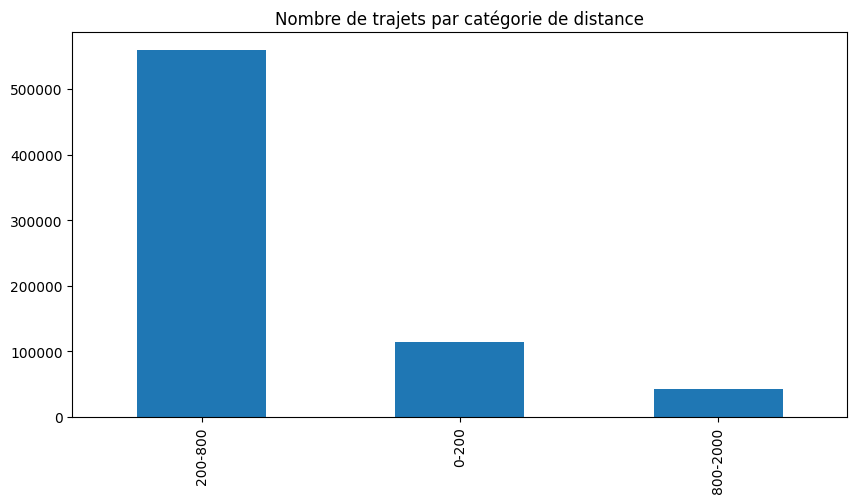

In [16]:
merged_data['distance_category'].value_counts().plot(kind="bar", 
                                                     title = "Nombre de trajets par catégorie de distance",
                                                     figsize=(10,5))

On remarque qu'il n'existe pas de catégorie de distance > 2000km. La plupart des distances sont comprises entre 200 et 800 km .

In [17]:
price_in_cents_comparison= merged_data.groupby(['distance_category','transport_type'])['price_in_cents',].mean().pivot_table(
                    columns='transport_type',
                    values='price_in_cents',
                    index=['distance_category'],
                )

In [18]:
price_in_cents_comparison

transport_type,bus,carpooling,train
distance_category,,,
0-200,1967.190813,1990.0,NaN
200-800,3397.145003,4338.5,3265.555556
800-2000,6112.710280,NaN,NaN


On remarque que le seul moyen pour faire un trajet de plus de 800km est de 
prendre le bus et que en moyenne il est moins chère de prendre un train pour une distance entre 200km et 800km.

<Axes: title={'center': 'Comparaison des prix par type de transport et catégorie de distance'}, xlabel='distance_category'>

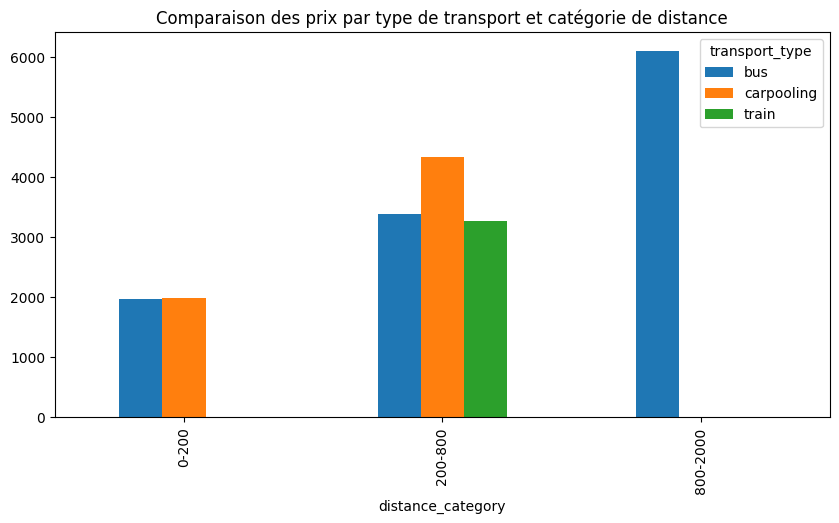

In [19]:
price_in_cents_comparison.plot(kind="bar", 
                               title="Comparaison des prix par type de transport et catégorie de distance",
                               figsize=(10,5))

In [20]:
merged_data['duration_in_minutes'] = merged_data['duration'].dt.total_seconds() / 60

In [21]:
duration_in_min_comparison= merged_data.groupby(['distance_category','transport_type'])['duration_in_minutes',].mean().pivot_table(
                    columns='transport_type',
                    values='duration_in_minutes',
                    index=['distance_category'],
                )

In [22]:
duration_in_min_comparison

transport_type,bus,carpooling,train
distance_category,,,
0-200,672.720848,855.00,NaN
200-800,844.936438,636.25,762.222222
800-2000,1465.116822,NaN,NaN


<Axes: title={'center': 'Comparaison des durées par type de transport et catégorie de distance'}, xlabel='distance_category'>

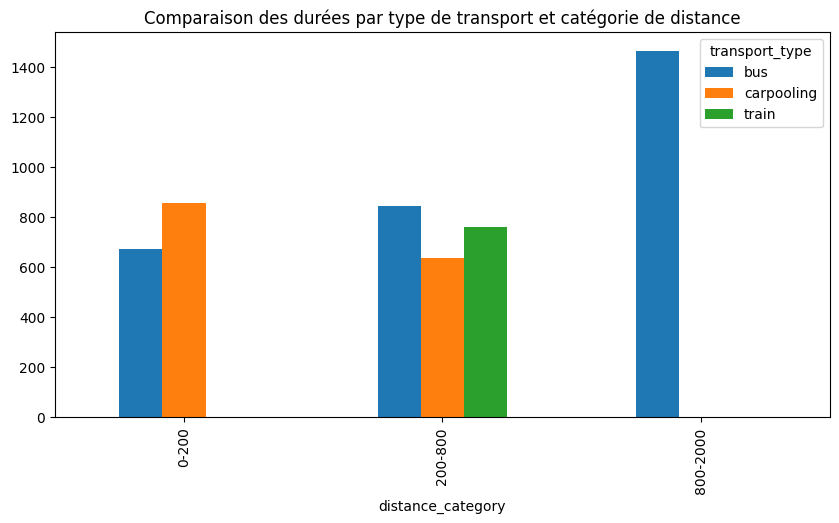

In [23]:
duration_in_min_comparison.plot(kind="bar",
                                title="Comparaison des durées par type de transport et catégorie de distance",
                                figsize=(10,5))

On peut remarquer que la durée de transport pour le carpooling décroit en moyenne avec la distance du trajet contrairement à celle du bus.

Si la distance est entre 200km et 800km et on privilégie la durée du trajet, il serait mieux d'opter pour le covoiturage. Il est le plus rapide.

# Prédiction des prix des tickets

In [24]:
merged_data["has_wifi"].isna().sum(),\
merged_data["has_plug"].isna().sum(),\
merged_data["has_adjustable_seats"].isna().sum(),\
merged_data["has_bicycle"].isna().sum()

(0, 0, 0, 0)

In [25]:
predictions_data= merged_data.copy()

In [26]:
predictions_data.head()

,id_x,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,id_y,local_name_o_city,unique_name_o_city,latitude_o_city,longitude_o_city,population_o_city,id_x,local_name_d_city,unique_name_d_city,latitude_d_city,longitude_d_city,population_d_city,id_y,unique_name_o_st,latitude_o_st,longitude_o_st,id_x,unique_name_d_st,latitude_d_st,longitude_d_st,id_y,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,duration,distance,distance_category,duration_in_minutes
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,16,9,NaN,distribusion,Distribusion,False,False,False,False,bus,0 days 17:50:00,504.32,200-800,1070.0
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,17,9,31,expressbusMunchen,Expressbus Munchen,False,False,False,False,bus,0 days 17:50:00,504.32,200-800,1070.0
2,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,18,9,33,berlinLinienBus,Berlin Linien Bus,False,False,False,False,bus,0 days 17:50:00,504.32,200-800,1070.0
3,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,19,9,37,ostfrieslandexpress,OstfrieslandExpress,False,False,False,False,bus,0 days 17:50:00,504.32,200-800,1070.0
4,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233,20,9,41,icBus,IC Bus,False,False,False,False,bus,0 days 17:50:00,504.32,200-800,1070.0


On enlève les colonnes qu'on aura pas besoin pour notre prédiction des prix.

In [27]:
predictions_data.drop(columns=['id_x', 'o_station', 'd_station', 'search_ts', 'middle_stations',
       'other_companies','local_name_o_city','unique_name_o_st',
       'latitude_o_st' ,	'longitude_o_st' , 'unique_name_d_st','latitude_d_st','longitude_d_st',
       'latitude_o_city', 'longitude_o_city','o_city', 'd_city',
       'population_o_city',  'local_name_d_city',
       'latitude_d_city', 'longitude_d_city', 'population_d_city', 'id_y',
       'company_id', 'provider_id', 'name','company','duration', 'distance'],axis=1, inplace=True)

In [28]:
predictions_data.head()

,departure_ts,arrival_ts,price_in_cents,unique_name_o_city,unique_name_d_city,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,distance_category,duration_in_minutes
0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,orleans,montpellier,Distribusion,False,False,False,False,bus,200-800,1070.0
1,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,orleans,montpellier,Expressbus Munchen,False,False,False,False,bus,200-800,1070.0
2,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,orleans,montpellier,Berlin Linien Bus,False,False,False,False,bus,200-800,1070.0
3,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,orleans,montpellier,OstfrieslandExpress,False,False,False,False,bus,200-800,1070.0
4,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,orleans,montpellier,IC Bus,False,False,False,False,bus,200-800,1070.0


In [29]:
predictions_data['departure_month']=pd.to_datetime(predictions_data['departure_ts'], format = "%Y-%m-%d %H:%M:%S").dt.month
predictions_data['departure_year']=pd.to_datetime(predictions_data['departure_ts'], format = "%Y-%m-%d %H:%M:%S").dt.year
predictions_data['arrival_month_month']=pd.to_datetime(predictions_data['arrival_ts'], format = "%Y-%m-%d %H:%M:%S").dt.month
predictions_data['arrival_year']=pd.to_datetime(predictions_data['arrival_ts'], format = "%Y-%m-%d %H:%M:%S").dt.year

In [30]:
predictions_data.head()

,departure_ts,arrival_ts,price_in_cents,unique_name_o_city,unique_name_d_city,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,distance_category,duration_in_minutes,departure_month,departure_year,arrival_month_month,arrival_year
0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,orleans,montpellier,Distribusion,False,False,False,False,bus,200-800,1070.0,10,2017,10,2017
1,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,orleans,montpellier,Expressbus Munchen,False,False,False,False,bus,200-800,1070.0,10,2017,10,2017
2,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,orleans,montpellier,Berlin Linien Bus,False,False,False,False,bus,200-800,1070.0,10,2017,10,2017
3,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,orleans,montpellier,OstfrieslandExpress,False,False,False,False,bus,200-800,1070.0,10,2017,10,2017
4,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,orleans,montpellier,IC Bus,False,False,False,False,bus,200-800,1070.0,10,2017,10,2017


In [31]:
predictions_data.drop(['departure_ts','arrival_ts'], axis=1, inplace =True)

In [32]:
# On convertit les booléens en integer 1 pour True et 0 pour False
predictions_data["has_wifi"] = predictions_data["has_wifi"].astype(int)
predictions_data["has_plug"] = predictions_data["has_plug"].astype(int)
predictions_data["has_adjustable_seats"] = predictions_data["has_adjustable_seats"].astype(int)
predictions_data["has_bicycle"] = predictions_data["has_bicycle"].astype(int)

In [33]:
# One-hot encoding sur nos données catégoriel
distance_category= pd.get_dummies(predictions_data['distance_category'], prefix = 'distance_category')
transport_type= pd.get_dummies(predictions_data['transport_type'], prefix = 'transport_type')
origin=pd.get_dummies(predictions_data['unique_name_o_city'], prefix = 'origin')
destination=pd.get_dummies(predictions_data['unique_name_d_city'], prefix = 'destination')
company_name=pd.get_dummies(predictions_data['fullname'], prefix = 'company')

In [34]:
predictions_data= pd.concat([predictions_data,company_name,distance_category,transport_type,origin,destination], axis=1)
predictions_data.head()

,price_in_cents,unique_name_o_city,unique_name_d_city,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,distance_category,duration_in_minutes,departure_month,departure_year,arrival_month_month,arrival_year,company_407 Pattana,company_88 Express Bus,company_99 Coachland Express,company_AS Karpaten Krim Tours,company_AUTOHERC,company_Adamis Tours,company_Adang Sea Tour,company_AeroBus,company_Air Decker,company_Air Ubon,"company_Alisan Golden Coach, One Utama",company_Andrade Voyages,company_Aran,company_Arda,company_AutobusOberbayern,company_Autotrans,company_BIGSIM Halilovic,company_Bangkok Busline,company_Bell Travel,company_Berlin Linien Bus,company_Berlin Shuttle,company_Billion Stars Express,company_Blue Line,company_Bozur,company_Brabusz,company_Budsarakham Tour,company_Burapha,company_Bus Express,company_Bus Operator,company_Busandfly,company_CS Travel Tours,company_Calanda Viaggi,company_Cepat Sedia Express,company_Chanapai Tour,company_Christian Transfers,company_CityBusExpress,company_Comati PSG,company_Corali Holidays,company_Crnja Tours,company_DB,company_DRD Turizem,company_Delima Express,company_Distribusion,company_Domo Reisen,company_Drinatrans,company_ECOLINES,company_ERA Mesra Express,company_EST Gdansk,company_Eagle Express,company_Eberhardt Travel,company_Eilat Shuttle,company_Elabus,company_Esan Tour,company_Eskana Bus,company_Etika Delta Sdn Bhd,company_Euro Bus,company_Eurobus Online,company_Euroclub,company_Eurolines UK,company_Europabus Cazin,company_Europabus Karlovac,company_Eurostar,company_ExpressBus,company_Expressbus Munchen,company_Fils,company_Fiumicino Express,company_Five Stars Executive Express,company_Flybus Iceland,company_GT Express,company_Galicja Express,company_Gameks d.o.o.,company_Globtour,company_GoOpti,company_Golden Coach Express,company_HKX,company_Hahn Express,company_Has Turizm,company_Hatyai Inter Top Express,company_Hidayah Sutera,company_HinzTravel,company_Huben,company_IC Bus,company_IRE BerlinHamburg,company_Interbus Kosice Express,company_Intercars Europe,company_Intercités,company_Intercités de Nuit,company_Jaska Turist,company_Jasmine Express,company_Jetbus,company_KKKL Express,company_KMK Starcoach,company_KPB Express,company_Kesatuan Express,company_Kingdom Tour,company_Komtar Gunung Raya,company_Konsortium Bas Ekspres,company_Kradueng Tour,company_Kraft Reisen,company_Kwan Chee Vee Tour,company_Kwok Ping Express,company_LAurora Viaggi,company_Lignite,company_Lignite Tour,company_Lotus Phibun Tour,company_Ludwig Reisen,company_Lviv Inturtrans,company_Madeltrans Eurolines,company_Magical Shuttle,company_MatzesMinibus,company_Mayang Sari Express,company_Mayer Mayer,company_Mikanovic Omnibus,company_Nakhon Si,company_National Express,company_Navette Keolis,company_Navette de Vatry,company_New Viriya,company_Niomit Tour,company_Nis Ekspres,company_ONEBUS,company_ORLAND REISEN,company_Ollex,company_OstfrieslandExpress,company_Panonijabus,company_Panturist,company_Pattaya Bus,company_Phantip 1970,company_Phet Prasert,company_Phu Luang Tour,company_Phuket Travel,company_Piya,company_Piya Chai Patthana,company_Piya Prasert Tour,company_Polluzha Tours,company_Polonia Tours,company_Postbus,company_Prague Airport Shuttle,company_Prakit Yon,company_Praya,company_Prem Pracha,company_Publicexpress,company_Pyrzowice Ekspres,company_Racic Eurobus,company_Radina VIP,company_Rally 13,company_Regionalverkehr Erzgebirge,company_Retman,company_Rung Kit,company_Rung Prasert,company_SE Express,company_SMS Flughafentransfer,company_Saeng Prathip Daeng,company_Sahaphan,company_Sappaisal,company_Sawadee Esan,company_Sawadee Tour,company_Schilling Omnibusverkehr,company_Schiphol Hotel Shuttle,company_Seasons Express,company_SemiTimeS,company_Siam First,company_Siam Lane Tour,company_Silvana Tour,company_Simeonidis Tours,company_Sindbad,company_SofiaBus,company_Sombat,company_Sport Turist,company_Srbija Tours International,company_Sri Mongkol,company_Sri Siam Tour,company

In [35]:
predictions_data.drop(['fullname','distance_category','transport_type','unique_name_o_city','unique_name_d_city'], axis=1,inplace=True)

In [36]:
predictions_data.head()

,price_in_cents,has_wifi,has_plug,has_adjustable_seats,has_bicycle,duration_in_minutes,departure_month,departure_year,arrival_month_month,arrival_year,company_407 Pattana,company_88 Express Bus,company_99 Coachland Express,company_AS Karpaten Krim Tours,company_AUTOHERC,company_Adamis Tours,company_Adang Sea Tour,company_AeroBus,company_Air Decker,company_Air Ubon,"company_Alisan Golden Coach, One Utama",company_Andrade Voyages,company_Aran,company_Arda,company_AutobusOberbayern,company_Autotrans,company_BIGSIM Halilovic,company_Bangkok Busline,company_Bell Travel,company_Berlin Linien Bus,company_Berlin Shuttle,company_Billion Stars Express,company_Blue Line,company_Bozur,company_Brabusz,company_Budsarakham Tour,company_Burapha,company_Bus Express,company_Bus Operator,company_Busandfly,company_CS Travel Tours,company_Calanda Viaggi,company_Cepat Sedia Express,company_Chanapai Tour,company_Christian Transfers,company_CityBusExpress,company_Comati PSG,company_Corali Holidays,company_Crnja Tours,company_DB,company_DRD Turizem,company_Delima Express,company_Distribusion,company_Domo Reisen,company_Drinatrans,company_ECOLINES,company_ERA Mesra Express,company_EST Gdansk,company_Eagle Express,company_Eberhardt Travel,company_Eilat Shuttle,company_Elabus,company_Esan Tour,company_Eskana Bus,company_Etika Delta Sdn Bhd,company_Euro Bus,company_Eurobus Online,company_Euroclub,company_Eurolines UK,company_Europabus Cazin,company_Europabus Karlovac,company_Eurostar,company_ExpressBus,company_Expressbus Munchen,company_Fils,company_Fiumicino Express,company_Five Stars Executive Express,company_Flybus Iceland,company_GT Express,company_Galicja Express,company_Gameks d.o.o.,company_Globtour,company_GoOpti,company_Golden Coach Express,company_HKX,company_Hahn Express,company_Has Turizm,company_Hatyai Inter Top Express,company_Hidayah Sutera,company_HinzTravel,company_Huben,company_IC Bus,company_IRE BerlinHamburg,company_Interbus Kosice Express,company_Intercars Europe,company_Intercités,company_Intercités de Nuit,company_Jaska Turist,company_Jasmine Express,company_Jetbus,company_KKKL Express,company_KMK Starcoach,company_KPB Express,company_Kesatuan Express,company_Kingdom Tour,company_Komtar Gunung Raya,company_Konsortium Bas Ekspres,company_Kradueng Tour,company_Kraft Reisen,company_Kwan Chee Vee Tour,company_Kwok Ping Express,company_LAurora Viaggi,company_Lignite,company_Lignite Tour,company_Lotus Phibun Tour,company_Ludwig Reisen,company_Lviv Inturtrans,company_Madeltrans Eurolines,company_Magical Shuttle,company_MatzesMinibus,company_Mayang Sari Express,company_Mayer Mayer,company_Mikanovic Omnibus,company_Nakhon Si,company_National Express,company_Navette Keolis,company_Navette de Vatry,company_New Viriya,company_Niomit Tour,company_Nis Ekspres,company_ONEBUS,company_ORLAND REISEN,company_Ollex,company_OstfrieslandExpress,company_Panonijabus,company_Panturist,company_Pattaya Bus,company_Phantip 1970,company_Phet Prasert,company_Phu Luang Tour,company_Phuket Travel,company_Piya,company_Piya Chai Patthana,company_Piya Prasert Tour,company_Polluzha Tours,company_Polonia Tours,company_Postbus,company_Prague Airport Shuttle,company_Prakit Yon,company_Praya,company_Prem Pracha,company_Publicexpress,company_Pyrzowice Ekspres,company_Racic Eurobus,company_Radina VIP,company_Rally 13,company_Regionalverkehr Erzgebirge,company_Retman,company_Rung Kit,company_Rung Prasert,company_SE Express,company_SMS Flughafentransfer,company_Saeng Prathip Daeng,company_Sahaphan,company_Sappaisal,company_Sawadee Esan,company_Sawadee Tour,company_Schilling Omnibusverkehr,company_Schiphol Hotel Shuttle,company_Seasons Express,company_SemiTimeS,company_Siam First,company_Siam Lane Tour,company_Silvana Tour,company_Simeonidis Tours,company_Sindbad,company_SofiaBus,company_Sombat,company_Sport Turist,company_Srbija Tours International,company_Sri Mongkol,company_Sri Siam Tour,company_Sri Suthep Tour,company_Sri Trang,company_Star Coach Express Sdn Bhd,company_St

In [37]:
X = predictions_data.drop('price_in_cents', axis=1)
y = predictions_data['price_in_cents']

In [38]:
# Définition du modèle 
model = DecisionTreeRegressor()

In [39]:
# Split des 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [40]:
model.fit(X_train,y_train)

DecisionTreeRegressor()

In [41]:
predictions =model.predict(X_test)

In [42]:
mse(y_test, model.predict(X_test))

200029.31113935425

In [43]:
print(f"R-Squared {model.score(X_test, y_test)}")

R-Squared 0.9215709245107991


Le modèle est précis à 92,15 %

In [44]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 195.75093923945823
MSE: 200029.31113935425
RMSE: 447.24636514940426


Un MAE de 195.76 signifie qu'en moyenne, les prédictions du modèle ont une erreur absolue de 195.76 cents par rapport aux valeurs réelles du prix.


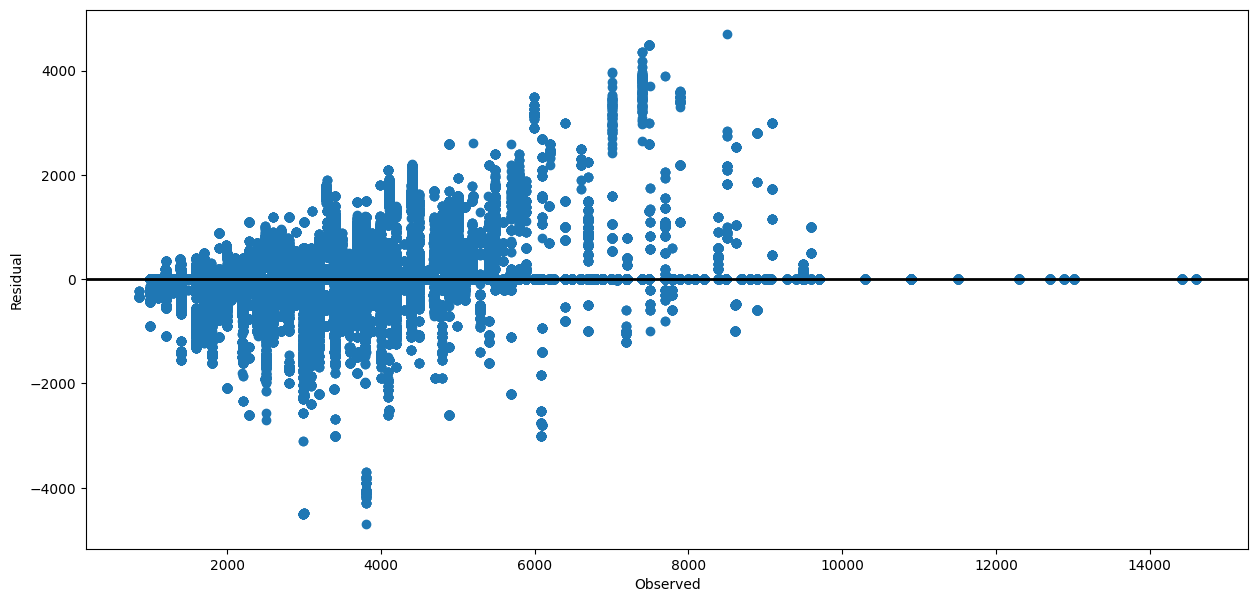

In [45]:
# Evaluating training model
residuals = y_test.values - predictions

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(y_test.values, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()